In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import cv2

plt.ion()   # interactive mode

In [5]:
%matplotlib inline

In [6]:
# Data preprocessing (data augmentation and normalisation)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Before proceeding make sure the data is split into train and val.
# In this case the data is split into 125 train and 75 test following the
# hymenoptera dataset split.

In [8]:
data_dir = 'data/welding_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

In [9]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                        shuffle = True, num_workers = 4)
              for x in ['train', 'val']}

In [10]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [11]:
class_names = image_datasets['train'].classes

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

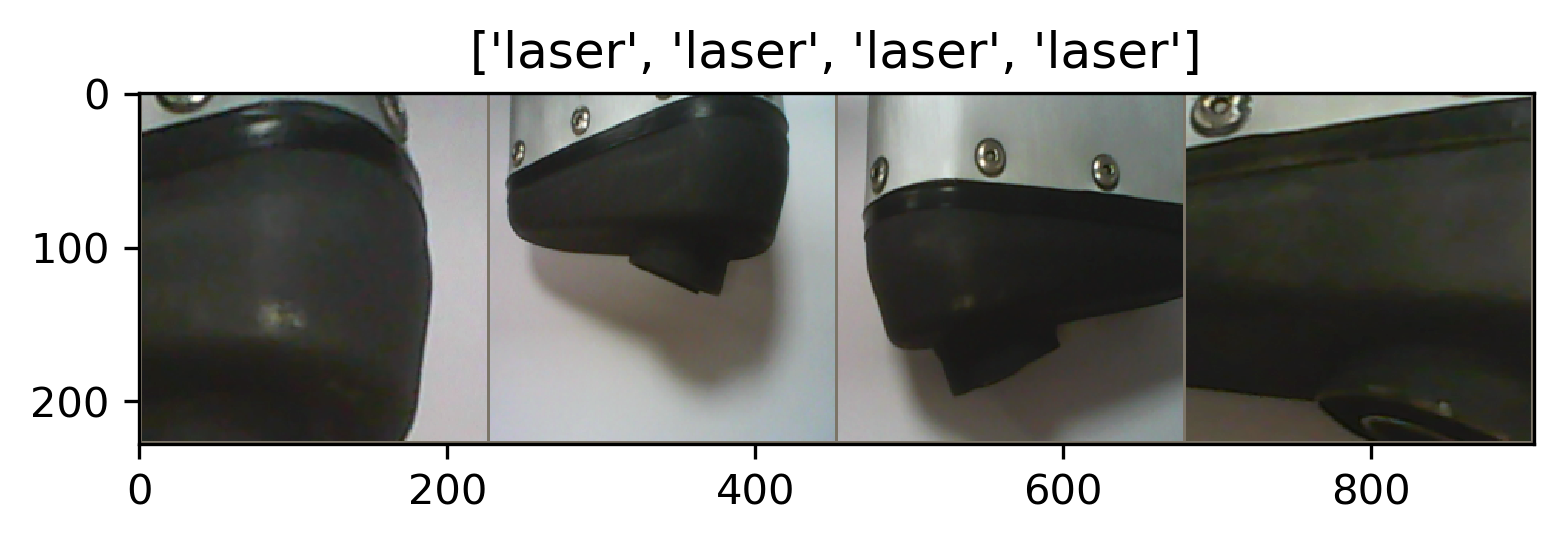

In [13]:
# Visualisation of a few images
# Increasing the dpi for better visualisation
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

# inputs, classes = next(iter(dataloaders['train']))
# out = torchvision.utils.make_grid(inputs)

# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    
# imshow(out, title=[class_names[x] for x in classes])

In [17]:
# Function to train the model and return the model with the best pred wieghts

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [34]:
# Function to diplay predictions of a few images

def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
# Finetuning the convnet 

# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6648 Acc: 0.6548
val Loss: 0.2292 Acc: 0.9533

Epoch 1/24
----------
train Loss: 0.6770 Acc: 0.7063
val Loss: 0.2585 Acc: 0.8600

Epoch 2/24
----------
train Loss: 0.4318 Acc: 0.8294
val Loss: 0.1296 Acc: 0.9667

Epoch 3/24
----------
train Loss: 0.5731 Acc: 0.7421
val Loss: 0.2381 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.4399 Acc: 0.8135
val Loss: 0.0693 Acc: 0.9733

Epoch 5/24
----------
train Loss: 0.3829 Acc: 0.8333
val Loss: 0.0793 Acc: 0.9733

Epoch 6/24
----------
train Loss: 0.6029 Acc: 0.7421
val Loss: 0.1244 Acc: 0.9667

Epoch 7/24
----------
train Loss: 0.3378 Acc: 0.8611
val Loss: 0.0481 Acc: 0.9800

Epoch 8/24
----------
train Loss: 0.2223 Acc: 0.9008
val Loss: 0.0462 Acc: 0.9800

Epoch 9/24
----------
train Loss: 0.2599 Acc: 0.9008
val Loss: 0.0468 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.2645 Acc: 0.8611
val Loss: 0.0508 Acc: 0.9800

Epoch 11/24
----------
train Loss: 0.3324 Acc: 0.8571
val Loss: 0.0499 Acc: 0.9867

Ep

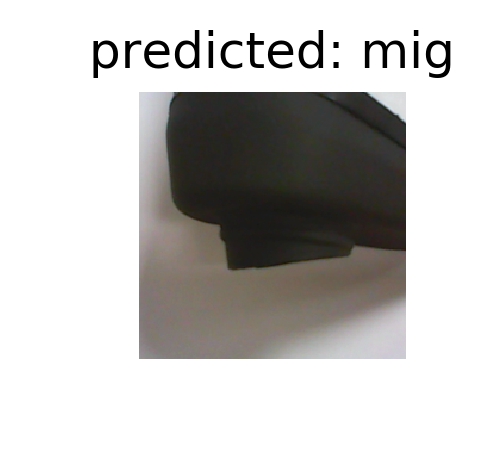

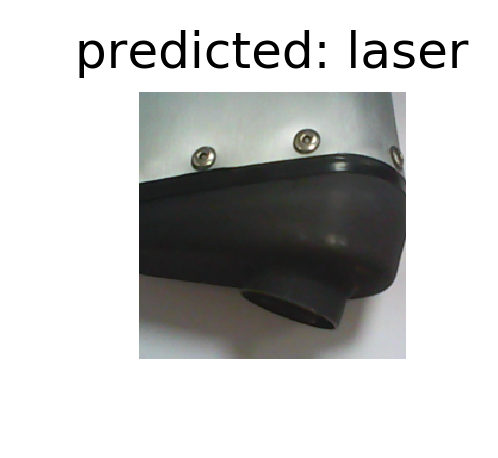

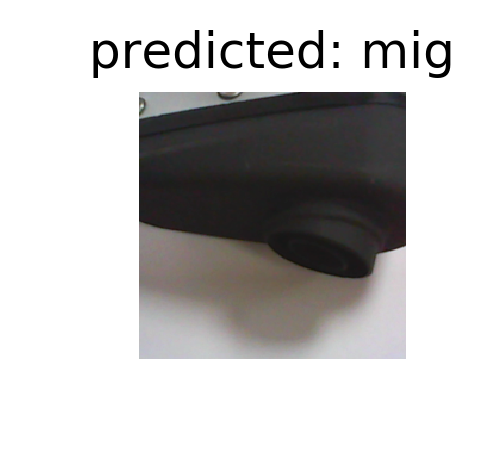

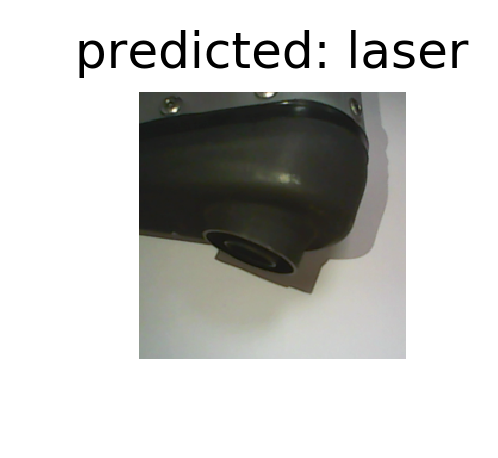

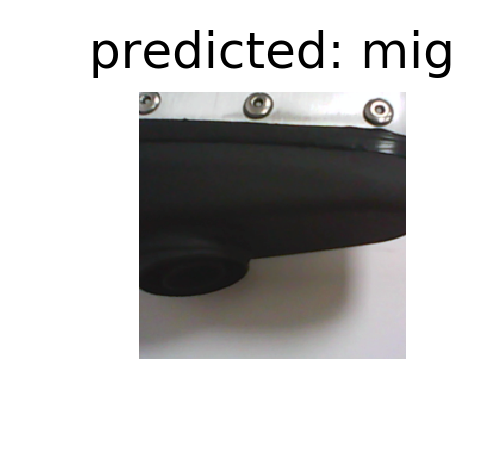

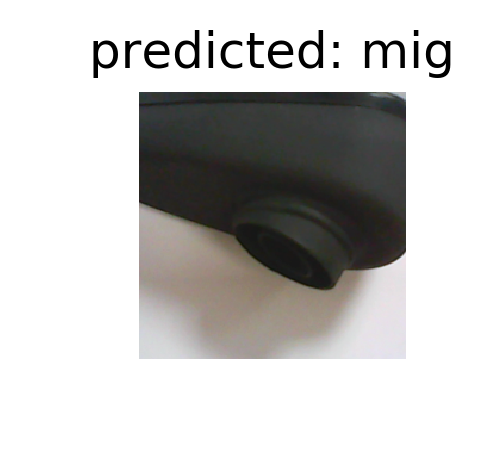

In [35]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
visualize_model(model_conv)

In [24]:
torch.save(model_conv.state_dict(), "weld_detection_conv.pth")